In [ ]:
!mkdir data
!wget https://github.com/DataScienceNigeria/Research-Papers-by-Data-Science-Nigeria/raw/master/AFRIFASHION1600:%20A%20Contemporary%20African%20Fashion%20Dataset%20for%20Computer%20Vision/data/AFRIFASHION1600.zip -P data
!unzip data/AFRIFASHION1600.zip -d data && rm data/AFRIFASHION1600.zip

mkdir: cannot create directory ‘data’: File exists
--2023-10-13 06:39:04--  https://github.com/DataScienceNigeria/Research-Papers-by-Data-Science-Nigeria/raw/master/AFRIFASHION1600:%20A%20Contemporary%20African%20Fashion%20Dataset%20for%20Computer%20Vision/data/AFRIFASHION1600.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DataScienceNigeria/Research-Papers-by-Data-Science-Nigeria/master/AFRIFASHION1600%3A%20A%20Contemporary%20African%20Fashion%20Dataset%20for%20Computer%20Vision/data/AFRIFASHION1600.zip [following]
--2023-10-13 06:39:04--  https://raw.githubusercontent.com/DataScienceNigeria/Research-Papers-by-Data-Science-Nigeria/master/AFRIFASHION1600%3A%20A%20Contemporary%20African%20Fashion%20Dataset%20for%20Computer%20Vision/data/AFRIFASHION1600.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

In [ ]:
path="/content/data"

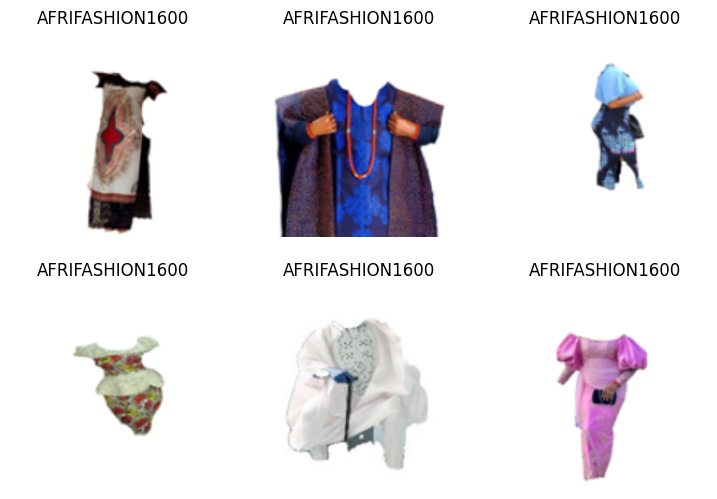

In [ ]:
from fastcore.all import *
from fastai.vision.all import *
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [ ]:
import os

DATA_DIR = '/content/data'
print(os.listdir(DATA_DIR))

['AFRIFASHION1600']


In [ ]:
print(os.listdir(DATA_DIR+'/AFRIFASHION1600')[:10])

['Agbada_53.png', 'Wrapper and Blouse_146.png', 'Gown_168.png', 'Wrapper and Blouse_179.png', 'Gown_122.png', 'African_Blouse_105.png', 'Wrapper and Blouse_32.png', 'Wrapper and Blouse_106.png', 'Skirt and Blouse_85.png', 'Gown_181.png']


In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


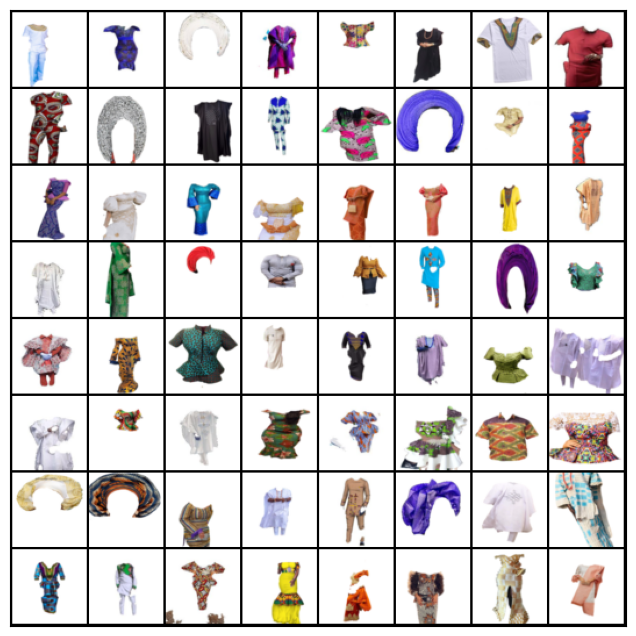

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cpu')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
import torch.nn as nn